In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# plt.style.use('dark_background')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.miscmodels.ordinal_model import OrderedModel

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
NORMALIZE_TARGET = True
TARGET_VARIABLE = 'ped_collisions'

# Data

In [3]:
features_df = pd.read_csv('data/processed/image_features.csv')
intersections_df = pd.read_csv('data/processed/intersection_collision_frequency.csv')
df = pd.merge(intersections_df, features_df, how='left', left_on='dupe_key', right_on='image_name')
display(df.head(3).T)
print(f'Shape: {df.shape}')

,0,1,2
lat,40.744167,40.681686,40.811651
lng,-73.91248,-73.87157,-73.914474
intersection,True,True,True
lat_int,40.744167,40.681686,40.811651
lng_int,-73.91248,-73.87157,-73.914474
...,...,...,...
cw_side3_length,NaN,159.380049,NaN
cw_side3_width,NaN,56.067243,NaN
cw_side4_length,NaN,493.82183,NaN
cw_side4_width,NaN,45.38479,NaN


Shape: (39162, 66)


In [4]:
df[df.total_collisions_sum > 0].shape

(33525, 66)

### Remove Low Quality Observations

In [5]:
df = df[df.placename == 'New York']
df = df[df.total_collisions_sum > 0]
df = df[df.intersection_total_count > 0]
df = df[df.overpass_center != 1]
df = df[df.overpass_area <= 0.5]
df = df.set_index('dupe_key', drop=True)
df = df.fillna(0)
df.shape

(27121, 65)

### Generate Features

In [6]:
def categorize_bike_infrastructure(row):
    has_signage = row['bikeLane_total_count'] > 0
    has_lane = row['bikeLaneInt_total_count'] > 0
    
    if has_signage and has_lane:
        return 3  # Complete infrastructure
    elif has_lane:
        return 2  # Lane only
    elif has_signage:
        return 1  # Signage only
    return 0     # No infrastructure

In [7]:
# Aggregations
df['bike_lane_signage_index'] = (0.7 * df['bikeLane_total_count'] + 0.3 * df['bikeLaneInt_total_count'])
# df['bike_lane_signage_index'] = df.apply(categorize_bike_infrastructure, axis=1)
df['max_int_length'] = df[['int_side1_length', 'int_side2_length', 'int_side3_length', 'int_side4_length']].max(axis=1)
df['int_perimeter'] = df['int_side1_length'] + df['int_side2_length'] + df['int_side3_length'] + df['int_side4_length']
df['total_crosswalk_length'] = df['cw_side1_length'] + df['cw_side2_length'] + df['cw_side3_length'] + df['cw_side4_length']
df['crosswalk_gap'] = df['int_perimeter'] - df['total_crosswalk_length']
df['avg_crosswalk_width'] = df[['cw_side1_width', 'cw_side2_width', 'cw_side3_width', 'cw_side4_width']].mean(axis=1)
df['complexity_index'] = (
    df['intersection_total_count'] + df['crosswalk_total_count'] + df['median_total_count'] + 
    df['doubleYellow_total_count'] # + df['busLane_total_count']
) # * df['intersection_main_area']

# Interactions
df['complexity_x_signage'] = df['complexity_index'] * df['bike_lane_signage_index']
df['complexity_x_width'] = df['complexity_index'] * df['avg_crosswalk_width']
df['buslane_x_bikelane'] = df['busLane_total_count'] * df['bike_lane_signage_index']
df['area_x_complexity'] = df['intersection_main_area'] * df['complexity_index']

# Polynomials
# TBD

df.shape

(27121, 76)

### Drop Irrelevant Features

In [8]:
df = df.drop([
    # Used for bike_lane_signage_index
    'bikeLane_total_count', 'bikeLaneInt_total_count', 'bikeLane_main_count', 'bikeLaneInt_main_count',
    # Used for int_perimeter
    'int_side1_length', 'int_side2_length', 'int_side3_length', 'int_side4_length',
    # Used for total_crosswalk_length and crosswalk_gap
    'cw_side1_length', 'cw_side2_length', 'cw_side3_length', 'cw_side4_length',
    # Used for avg_crosswalk_width
    'cw_side1_width', 'cw_side2_width', 'cw_side3_width', 'cw_side4_width',
    # Used for complexity_index
    'intersection_total_count', 'crosswalk_total_count', 'median_total_count', 'doubleYellow_total_count',
    # Not used
    'crosswalk_main_count', 'median_main_count', 'doubleYellow_main_count', 'busLane_main_count',
    'overpass_main_count', 'overpass_total_count', 
    # Found to be near-constant
    'overhead_area', 'overpass_center',
    # Multicolinearity
    'int_perimeter', 'total_crosswalk_length', # 'boro_name',
    # Leftover features from initial queries
    'image_name', 'lat', 'lng', 'intersection', 'lat_int', 'lng_int', 'mtfcc1', 'mtfcc2',
    'adminCode1', 'adminName1', 'distance_site_int', 'distance', 'bearing', 'placename', 
    'street1Bearing', 'street2Bearing', 'postalcode', 'countryCode', 'street1', 'street2',
    'adminName2'
], axis=1)

df.shape

(27121, 25)

### Normalize Features

In [9]:
scaler = MinMaxScaler()
numerical_predictors = [x for x in df.columns if '_sum' not in x and x != 'boro_name']
df[numerical_predictors] = scaler.fit_transform(df[numerical_predictors])

numerical_predictors

['busLane_total_count',
 'overpass_area',
 'intersection_main_area',
 'bike_lane_signage_index',
 'max_int_length',
 'crosswalk_gap',
 'avg_crosswalk_width',
 'complexity_index',
 'complexity_x_signage',
 'complexity_x_width',
 'buslane_x_bikelane',
 'area_x_complexity']

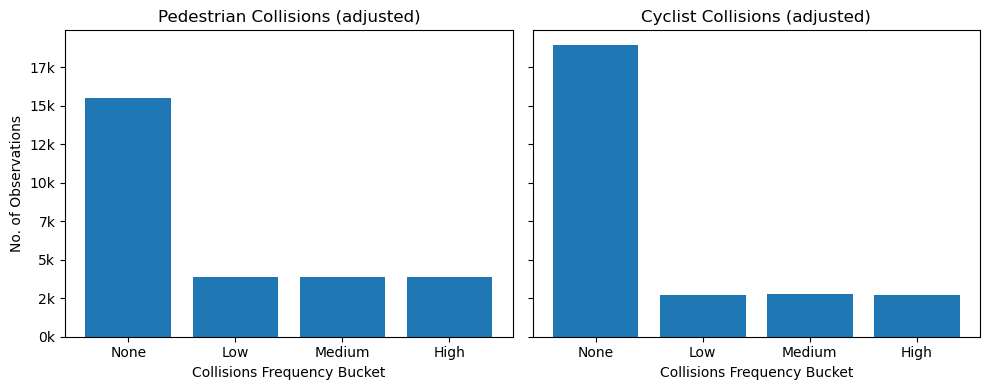

In [10]:
manual_cutoffs = {
    'ped': np.array([-1.,  0.0012987,  0.09302326,  0.19444444,  1.]),
    'cyc': np.array([-1.,  0.0012987,  0.07407407,  0.15873016,  1.]),
}
categories = ['None', 'Low', 'Medium', 'High']

df['ped_collisions'] = df['ped_collisions_sum'] / df['total_collisions_sum']
df['cyc_collisions'] = df['cyc_collisions_sum'] / df['total_collisions_sum']

df['ped_collisions_buckets'] = pd.cut(df['ped_collisions'], bins=manual_cutoffs['ped'], labels=categories)
df['cyc_collisions_buckets'] = pd.cut(df['cyc_collisions'], bins=manual_cutoffs['cyc'], labels=categories)

cat_type = pd.api.types.CategoricalDtype(categories=categories, ordered=True)
df['ped_collisions_buckets'] = df['ped_collisions_buckets'].astype(cat_type)
df['cyc_collisions_buckets'] = df['cyc_collisions_buckets'].astype(cat_type)

# Create value counts with consistent ordering
ped_counts = df['ped_collisions_buckets'].value_counts().reindex(categories)
cyc_counts = df['cyc_collisions_buckets'].value_counts().reindex(categories)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].bar(ped_counts.index, ped_counts.values)
axes[1].bar(cyc_counts.index, cyc_counts.values)

axes[0].set_title('Pedestrian Collisions (adjusted)')
axes[0].set_xlabel('Collisions Frequency Bucket')
axes[0].set_ylabel('No. of Observations')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

axes[1].set_title('Cyclist Collisions (adjusted)')
axes[1].set_xlabel('Collisions Frequency Bucket')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.show()

### Normalize Target and Define Buckets

In [11]:
def optimize_buckets(df, collision_col, max_buckets=6):
   from sklearn.metrics import silhouette_score
   from sklearn.preprocessing import KBinsDiscretizer
   
   # Separate zero and non-zero collisions
   non_zero_mask = df[collision_col] > 0
   X = df.loc[non_zero_mask, collision_col].values.reshape(-1, 1)
   
   scores = {}
   cutoffs = {}
   
   for n_bins in range(2, max_buckets):  # -1 to account for zero bin
       for strategy in ['uniform', 'quantile']:
           discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
           labels = discretizer.fit_transform(X).ravel()
           
           if len(np.unique(labels)) > 1:
               score = silhouette_score(X, labels)
               scores[f'{n_bins+1}_{strategy}'] = score  # +1 to account for zero bin
               edges = np.insert(discretizer.bin_edges_[0], 0, -1)  # Add zero boundary
               cutoffs[f'{n_bins+1}_{strategy}'] = edges
   
   return scores, cutoffs

In [12]:
if NORMALIZE_TARGET:
    df[f'{TARGET_VARIABLE}'] = (df[f'{TARGET_VARIABLE}_sum'] / df['total_collisions_sum']).fillna(0)
else:
    df[f'{TARGET_VARIABLE}'] = df[f'{TARGET_VARIABLE}_sum']

scores, cutoffs = optimize_buckets(df, f'{TARGET_VARIABLE}')

display(pd.DataFrame(scores, index=['Silhouette Score']))
display(cutoffs)

,3_uniform,3_quantile,4_uniform,4_quantile,5_uniform,5_quantile,6_uniform,6_quantile
Silhouette Score,0.778515,0.433469,0.664209,0.401169,0.634833,0.418791,0.61018,0.428066


{'3_uniform': array([-1.        ,  0.0012987 ,  0.50064935,  1.        ]),
 '3_quantile': array([-1.        ,  0.0012987 ,  0.13461538,  1.        ]),
 '4_uniform': array([-1.        ,  0.0012987 ,  0.33419913,  0.66709957,  1.        ]),
 '4_quantile': array([-1.        ,  0.0012987 ,  0.09302326,  0.19444444,  1.        ]),
 '5_uniform': array([-1.        ,  0.0012987 ,  0.25097403,  0.50064935,  0.75032468,
         1.        ]),
 '5_quantile': array([-1.        ,  0.0012987 ,  0.07317073,  0.13461538,  0.24      ,
         1.        ]),
 '6_uniform': array([-1.        ,  0.0012987 ,  0.20103896,  0.40077922,  0.60051948,
         0.80025974,  1.        ]),
 '6_quantile': array([-1.        ,  0.0012987 ,  0.0625    ,  0.10810811,  0.16666667,
         0.2743833 ,  1.        ])}

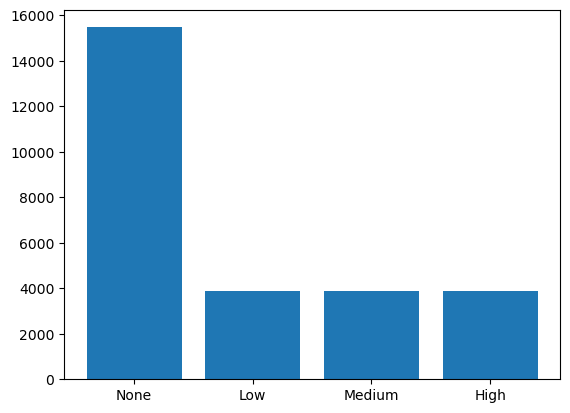

ped_collisions_buckets
None      15479
Low        3888
Medium     3877
High       3877
Name: count, dtype: int64

In [13]:
cutoffs = cutoffs['4_quantile']
categories = ['None', 'Low', 'Medium', 'High']

df[f'{TARGET_VARIABLE}_buckets'] = pd.cut(df[f'{TARGET_VARIABLE}'], bins=cutoffs, labels=categories)
cat_type = pd.api.types.CategoricalDtype(categories=categories, ordered=True)
df[f'{TARGET_VARIABLE}_buckets'] = df[f'{TARGET_VARIABLE}_buckets'].astype(cat_type)

plt.figure()
plt.bar(df[f'{TARGET_VARIABLE}_buckets'].value_counts().index, df[f'{TARGET_VARIABLE}_buckets'].value_counts().values)
plt.show()

display(df[f'{TARGET_VARIABLE}_buckets'].value_counts())

# Fit Model

In [14]:
# Prepare data for ordinal regression
X = df[[
    x for x in df.columns 
    if '_collision' not in x
    and '_sum' not in x
    and x != 'boro_name'
]]
y = df[f'{TARGET_VARIABLE}_buckets']

# Fit an ordinal regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Summarize the results
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.082003
         Iterations: 161
         Function evaluations: 163
         Gradient evaluations: 163
                               OrderedModel Results                               
Dep. Variable:     ped_collisions_buckets   Log-Likelihood:                -29345.
Model:                       OrderedModel   AIC:                         5.872e+04
Method:                Maximum Likelihood   BIC:                         5.884e+04
Date:                    Sun, 15 Dec 2024                                         
Time:                            14:32:44                                         
No. Observations:                   27121                                         
Df Residuals:                       27106                                         
Df Model:                              12                                         
                              coef    std err          z      P>|z|      [0.02

### Diagnostics

In [15]:
def test_proportional_odds(features_df, target_series):
    """
    Test proportional odds assumption using likelihood ratio test.
    Compare constrained (proportional odds) vs unconstrained models.
    
    Parameters:
    features_df (pd.DataFrame): DataFrame containing feature columns
    target_series (pd.Series): Series containing ordinal outcome variable
    """
    from scipy import stats

    # Fit original model (constrained)
    constrained_model = OrderedModel(
        target_series, features_df, distr='logit'
    ).fit(maxiter=5000)
    ll_constrained = constrained_model.llf

    # Fit separate binary models for each threshold
    ll_unconstrained = 0
    categories = target_series.cat.categories  # Get ordered categories
    
    for i in range(len(categories) - 1):
        # Create binary outcome for this threshold
        binary_outcome = (target_series > categories[i]).astype(int)
        
        # Fit binary logistic regression
        binary_model = sm.Logit(binary_outcome, features_df).fit(disp=0)
        ll_unconstrained += binary_model.llf
    
    # Calculate likelihood ratio test statistic
    lr_stat = -2 * (ll_constrained - ll_unconstrained)
    df_diff = len(features_df.columns) * (len(categories) - 2)  # degrees of freedom
    p_value = stats.chi2.sf(lr_stat, df_diff)
    
    results = {
        'test_statistic': lr_stat,
        'degrees_of_freedom': df_diff,
        'p_value': p_value,
        'proportional_odds_assumed': p_value > 0.05
    }
    
    # Print results in a readable format
    print("\nProportional Odds Assumption Test Results:")
    print(f"Test Statistic: {lr_stat:.2f}")
    print(f"Degrees of Freedom: {df_diff}")
    print(f"P-value: {p_value:.4f}")
    print(f"Assumption holds: {p_value > 0.05}")
    
    return results

def calculate_pseudo_r2_metrics(model_results):
    """
    Calculate multiple pseudo R-squared measures
    """
    ll_null = model_results.llnull  # Log-likelihood of null model
    ll_model = model_results.llf    # Log-likelihood of fitted model
    n = model_results.nobs          # Number of observations
    
    # McFadden's R-squared
    mcfadden = 1 - (ll_model / ll_null)
    
    # McKelvey & Zavoina's R-squared
    # Particularly suitable for ordinal regression
    variance_factor = np.pi**2 / 3  # For logistic distribution
    predicted_values = model_results.predict()
    var_predicted = np.var(predicted_values)
    mz_r2 = var_predicted / (var_predicted + variance_factor)
    
    # Adjusted McFadden
    k = len(model_results.params)  # Number of parameters
    mcfadden_adj = 1 - ((ll_model - k) / ll_null)
    
    return {
        'mcfadden_r2': mcfadden,
        'mcfadden_r2_adj': mcfadden_adj,
        'mckelvey_zavoina_r2': mz_r2
    }

def evaluate_ordinal_predictions(true_values, predicted_values, categories):
    """
    Calculate ordinal-specific classification metrics for string labels
    """
    from sklearn.metrics import confusion_matrix
    import numpy as np
    
    # Convert strings to pandas Series if they aren't already
    true_values = pd.Series(true_values)
    predicted_values = pd.Series(predicted_values)
    
    # Define conversion dictionary
    cat_to_num = {k:v for v, k in enumerate(categories)}
    
    # Convert strings to numeric values
    true_numeric = true_values.astype(str).map(cat_to_num).values
    pred_numeric = predicted_values.astype(str).map(cat_to_num).values
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_values, predicted_values, labels=categories)
    
    # Calculate metrics
    mae = np.mean(np.abs(true_numeric - pred_numeric))
    
    # Adjacent Category Error Rate
    adjacent_errors = np.sum(np.abs(true_numeric - pred_numeric) == 1)
    total_errors = np.sum(true_numeric != pred_numeric)
    adjacent_error_rate = adjacent_errors / total_errors if total_errors > 0 else 0
    
    # Weighted Kappa
    from sklearn.metrics import cohen_kappa_score
    weighted_kappa = cohen_kappa_score(true_numeric, pred_numeric, weights='linear')
    
    # Print results
    print("\nClassification Metrics:")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Adjacent Error Rate: {adjacent_error_rate:.3f}")
    print(f"Weighted Kappa: {weighted_kappa:.3f}")
    print("\nConfusion Matrix:")
    print(pd.DataFrame(
        conf_matrix, 
        index=categories,
        columns=categories
    ))
    
    return {
        'confusion_matrix': conf_matrix,
        'mean_absolute_error': mae,
        'adjacent_error_rate': adjacent_error_rate,
        'weighted_kappa': weighted_kappa
    }

Proportional Odds Test

p > 0.05: Assumption holds  
p < 0.05: Consider separate binary models or alternative approaches  
In your case, violation might indicate that features affect different risk levels differently

In [16]:
results = test_proportional_odds(X, y)

Optimization terminated successfully.
         Current function value: 1.092206
         Iterations: 3404
         Function evaluations: 4511

Proportional Odds Assumption Test Results:
Test Statistic: -25399.61
Degrees of Freedom: 24
P-value: 1.0000
Assumption holds: True


Pseudo R-squared

McFadden's: Values between 0.2-0.4 typically indicate good fit  
McKelvey & Zavoina's: More comparable to linear regression R-squared  
Use these to compare different model specifications

In [17]:
calculate_pseudo_r2_metrics(result)

{'mcfadden_r2': 0.06295546204637636,
 'mcfadden_r2_adj': 0.06247648195952471,
 'mckelvey_zavoina_r2': 0.014168630173031146}

Classification Metrics

MAE: Interpret in terms of category distances  
Adjacent Error Rate: High rates (>80%) suggest predictions are "close"  
Weighted Kappa: Values > 0.6 indicate substantial agreement

In [18]:
int_to_labels = {k:v for k, v in enumerate(categories)}
predictions = result.predict(X, which='prob').idxmax(axis=1).map(int_to_labels)
results = evaluate_ordinal_predictions(y, predictions, categories)


Classification Metrics:
Mean Absolute Error: 0.857
Adjacent Error Rate: 0.334
Weighted Kappa: 0.037

Confusion Matrix:
         None  Low  Medium  High
None    15383    0       0    96
Low      3648    0       0   240
Medium   3641    0       0   236
High     3773    0       0   104


In [19]:
# Check if relationships hold across different boroughs
borough_coefs = pd.DataFrame()
borough_p_vals = pd.DataFrame()
for borough in df['boro_name'].unique():
    borough_df = df[df['boro_name'] == borough]
    X_borough = X[df['boro_name'] == borough]
    y_borough = y[df['boro_name'] == borough]
    
    model_borough = OrderedModel(y_borough, X_borough, distr='logit')
    result_borough = model_borough.fit(method='bfgs')
    coefs = pd.DataFrame({borough: result_borough.params})
    p_vals = pd.DataFrame({borough: result_borough.pvalues})
    
    borough_coefs = pd.concat([borough_coefs, coefs], axis=1)
    borough_p_vals = pd.concat([borough_p_vals, p_vals], axis=1)

Optimization terminated successfully.
         Current function value: 1.216811
         Iterations: 140
         Function evaluations: 142
         Gradient evaluations: 142
Optimization terminated successfully.
         Current function value: 0.913728
         Iterations: 175
         Function evaluations: 178
         Gradient evaluations: 178
Optimization terminated successfully.
         Current function value: 1.337673
         Iterations: 156
         Function evaluations: 158
         Gradient evaluations: 158
Optimization terminated successfully.
         Current function value: 1.134826
         Iterations: 152
         Function evaluations: 154
         Gradient evaluations: 154
Optimization terminated successfully.
         Current function value: 0.715584
         Iterations: 170
         Function evaluations: 173
         Gradient evaluations: 173


In [20]:
display(round(borough_coefs, 3))
display(round(borough_p_vals, 3))

,Brooklyn,Queens,Manhattan,Bronx,Staten Island
busLane_total_count,0.113,0.787,1.121,0.670,1.079
overpass_area,-0.162,0.114,-0.106,-0.089,-1.072
intersection_main_area,2.641,4.312,1.181,-1.533,2.781
bike_lane_signage_index,-0.595,1.879,1.339,1.138,-0.186
max_int_length,0.159,0.021,1.581,1.091,2.764
crosswalk_gap,-1.893,-2.102,-1.571,-1.479,-3.777
avg_crosswalk_width,2.922,2.969,2.929,3.916,0.808
complexity_index,1.597,5.371,1.706,2.337,5.599
complexity_x_signage,0.606,-2.184,-1.593,-0.756,3.219
complexity_x_width,-1.034,-2.804,-2.279,-3.597,-0.708


,Brooklyn,Queens,Manhattan,Bronx,Staten Island
busLane_total_count,0.778,0.006,0.005,0.043,0.344
overpass_area,0.559,0.728,0.812,0.816,0.331
intersection_main_area,0.007,0.000,0.392,0.219,0.243
bike_lane_signage_index,0.129,0.000,0.072,0.062,0.913
max_int_length,0.759,0.968,0.009,0.118,0.016
crosswalk_gap,0.003,0.001,0.092,0.073,0.007
avg_crosswalk_width,0.000,0.000,0.000,0.000,0.534
complexity_index,0.017,0.000,0.159,0.004,0.000
complexity_x_signage,0.414,0.023,0.276,0.495,0.398
complexity_x_width,0.373,0.018,0.218,0.032,0.829


In [ ]:
def stability_analysis(df, X, y):
    # Base model
    base_result = OrderedModel(y, X, distr='logit').fit(method='bfgs')
    base_coef = base_result.params
    base_pvals = base_result.pvalues
    
    # Remove top 5% most complex intersections
    complex_threshold = df['complexity_index'].quantile(0.95)
    reduced_mask = df['complexity_index'] < complex_threshold
    reduced_result = OrderedModel(y[reduced_mask], X[reduced_mask], distr='logit').fit(method='bfgs')
    reduced_coef = reduced_result.params
    reduced_pvals = reduced_result.pvalues

    # Compare coefficients
    coef_comparison = pd.DataFrame({
        'base_model': base_coef,
        'reduced_model': reduced_coef
    })
    pval_comparison = pd.DataFrame({
        'base_model': base_pvals,
        'reduced_model': reduced_pvals
    })
    return coef_comparison, pval_comparison

stability_analysis(df, X, y)

Optimization terminated successfully.
         Current function value: 1.082003
         Iterations: 161
         Function evaluations: 163
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: 1.065076
         Iterations: 176
         Function evaluations: 178
         Gradient evaluations: 178


,base_model,reduced_model
busLane_total_count,0.698565,0.661449
overpass_area,0.146639,0.165055
intersection_main_area,1.621373,2.878418
bike_lane_signage_index,1.060119,1.480984
max_int_length,0.806798,1.200422
crosswalk_gap,-1.426595,-1.839232
avg_crosswalk_width,4.523323,3.922225
complexity_index,4.116729,4.554272
complexity_x_signage,-1.054163,-2.153936
complexity_x_width,-4.508367,-3.232819


In [23]:
result.pvalues

busLane_total_count        2.560942e-05
overpass_area              3.808665e-01
intersection_main_area     1.686224e-03
bike_lane_signage_index    1.397348e-05
max_int_length             2.042878e-03
crosswalk_gap              1.646996e-05
avg_crosswalk_width        3.491029e-73
complexity_index           3.836371e-33
complexity_x_signage       2.489605e-02
complexity_x_width         1.652939e-12
buslane_x_bikelane         4.612607e-01
area_x_complexity          6.206274e-07
None/Low                   3.799621e-55
Low/Medium                 6.938629e-99
Medium/High                9.602906e-07
dtype: float64